### Generating Data

Below we choose 100 different starting points for the Lorenz system and calculate the trajectory for 8 seconds in time. We will use this to train our neural network. This will allow the network to act as a time-stepper : given a point (x,y,z) it can calculate the new point (x', y', z') dt seconds further in time.

(256, 251)
(256, 1)
(1, 251)


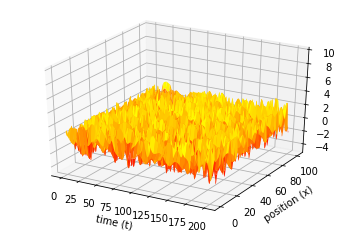

(5250, 256)
(5250, 256)


In [34]:
import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import os

%matplotlib inline

max_train_size = 100 # max number of initial conditions to use for data
curr_train_size = 0


# Load data for this system
for f in os.scandir('./data/'):

    if curr_train_size >= max_train_size: break
        
    if 'kuramoto' in f.name and 'train' in f.name:
        data = scipy.io.loadmat(f.path)
        uu = data['uu']
        
        # Construct inputs and expected outputs (i.e. prediction dt into the future)
        if curr_train_size == 0:
            inputs = uu.T[:-1, :]
            outputs = uu.T[1:, :]
        else:
            inputs = np.vstack((inputs, uu.T[:-1, :]))
            outputs = np.vstack((outputs, uu.T[1:, :]))
            
        curr_train_size += 1





# just a small glimpse of what the system looks like at one particular initial condition
uu = data['uu']
x = data['x']
tt = data['tt']

print(uu.shape)
print(x.shape)
print(tt.shape)

fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, uu, cmap='autumn')

plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)

print(inputs.shape)
print(outputs.shape)

### Training A neural Network

Here we define a standard 3-layer feedforward neural network with 20 neurons in each layer

In [76]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

l1 = 1e-10  # L1 regularization of network weights\
l2 = 1e-10 # L2 Regularization of network weights

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(1000, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), input_shape = (uu.shape[0],)))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, activation='linear'))

model.add(Dense(uu.shape[0], activation='linear'))

model.compile(optimizer='adadelta', loss='mean_squared_error')


In [77]:
model.fit(inputs, outputs, 
         epochs=100,
         batch_size=100,
         shuffle=True, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Train on 4200 samples, validate on 1050 samples
Epoch 1/100
4200/4200 [==============================] - 7s 2ms/step - loss: 1.7785 - val_loss: 1.6947
Epoch 2/100
4200/4200 [==============================] - 4s 1ms/step - loss: 1.2390 - val_loss: 1.6220
Epoch 3/100
4200/4200 [==============================] - 4s 1ms/step - loss: 0.9225 - val_loss: 0.9942
Epoch 4/100
4200/4200 [==============================] - 4s 1ms/step - loss: 0.7570 - val_loss: 0.9665
Epoch 5/100
4200/4200 [==============================] - 4s 1ms/step - loss: 0.6088 - val_loss: 0.9369
Epoch 6/100
4200/4200 [==============================] - 4s 1ms/step - loss: 0.5272 - val_loss: 0.8659
Epoch 7/100
4200/4200 [==============================] - 4s 1ms/step - loss: 0.4247 - val_loss: 0.7243
Epoch 8/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.3586 - val_loss: 0.7853
Epoch 9/100
4200/4200 [==============================] - 4s 1ms/step - loss: 0.2991 - val_loss: 0.6817
Epoch 10/100
4200/4200 [=

4200/4200 [==============================] - 5s 1ms/step - loss: 0.0106 - val_loss: 0.4758
Epoch 80/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0109 - val_loss: 0.4735
Epoch 81/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0124 - val_loss: 0.4906
Epoch 82/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0143 - val_loss: 0.4713
Epoch 83/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0132 - val_loss: 0.4764
Epoch 84/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0132 - val_loss: 0.4730
Epoch 85/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0119 - val_loss: 0.4733
Epoch 86/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0197 - val_loss: 0.4753
Epoch 87/100
4200/4200 [==============================] - 5s 1ms/step - loss: 0.0188 - val_loss: 0.4745
Epoch 88/100
4200/4200 [==============================] - 5s 1ms/step - loss:

### Analyzing Training

Analyze the loss of the neural net (on both the training and validation datasets) as a function of epochs

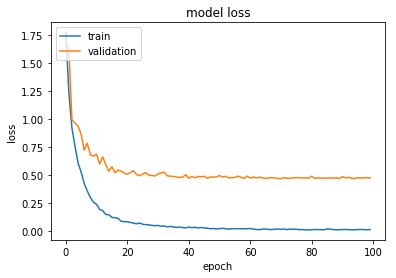

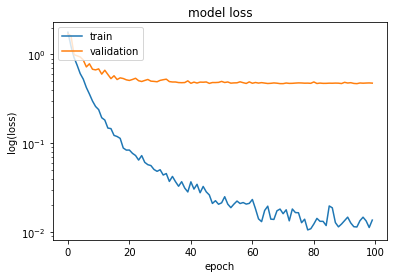

In [78]:
%matplotlib inline

# summarize history for loss
plt.figure(2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.figure(3)
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')



### Test Performance of Neural Net

Here, we will generate new trajectories using a random starting condition. Using both an ode solver and our neural network, we will predict the trajectories of the points.

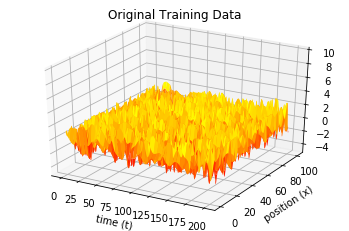

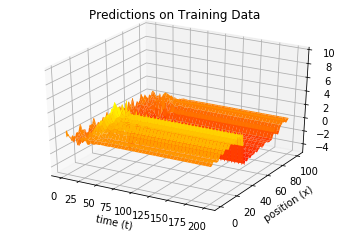

In [79]:
%matplotlib inline

# performance on training data

y_NN = np.zeros(uu.shape)
y_NN[:, 0] = uu[:, 0]

for i in range(1, y_NN.shape[1]):
    y_NN[:, i] = model.predict(np.expand_dims(y_NN[:, i-1], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, uu, cmap='autumn')
plt.title('Original Training Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)

fig = plt.figure(5)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, y_NN, cmap='autumn')
plt.title('Predictions on Training Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)




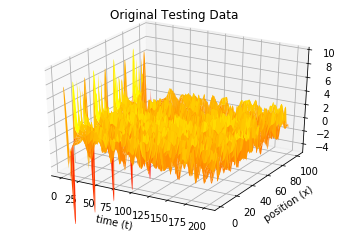

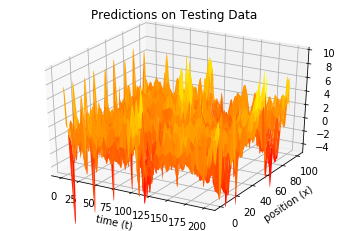

In [47]:
# LOAD TESTING DATA

test_data = scipy.io.loadmat('./data/kuramoto_sivishinky_test2.mat')
uu_test = test_data['uu']
# performance on testing data


y_NN = np.zeros(uu_test.shape)
y_NN[:, 0] = uu_test[:, 0]

for i in range(1, y_NN.shape[1]):
    y_NN[:, i] = model.predict(np.expand_dims(y_NN[:, i-1], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, uu_test, cmap='autumn')
plt.title('Original Testing Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)

fig = plt.figure(5)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, y_NN, cmap='autumn')
plt.title('Predictions on Testing Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)